In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, classification_report

In [2]:
from models import *

## 1. Data

In [3]:
data = pd.read_csv('pnad_clean.csv')

In [4]:
cols = ['nadults', 'nrooms', 'nbedrooms', 'nbathrooms', 'urban', 'age', 'gender',
        'mixed', 'id', 'cellphone', 'readwrite', 'employed', 'morethan1job', 'employee', 'entrepreneur',
        'meaneduc', 'agefirstjob', 'nkids', 'ndeadkids', 'npeople', 'nmen', 'neapeople', 'nold', 'south',
        'southborn', 'school', 'private', 'childworks', 'maxeduc', 'educhead', 'headmale', 'sharehh', 'livesabroad',
        'headfc', 'headfirstjob', 'married', 'college', 'highschool', 'union', 'jobagric', 'jobind', 'jobconstr',
        'jobret', 'jobcomms', 'jobgovt', 'jobmaid', 'jobhighskills', 'anyhelp', 'menwomen', 'dependency', 'phone_fix',
        'radio', 'tv', 'tvbw', 'dvd', 'fridge', 'computer', 'washer', 'car', 'motorbike', 'carbike', 'water', 'sewer', 
        'natgas', 'trash_collection', 'electricity', 'internet', 'apt', 'roofjute', 'walljute', 'waternet',
        'waterwell', 'stove', 'waterfilter', 'peopleroom', 'regmetrop', 'region1', 'region2', 'region5', 'kid',
        'kidschool', 'kidprivate', 'agesq', 'maintratio', 'stove_botgas', 'ownsland', 'ownshouse']

In [5]:
# total = X.isnull().sum().sort_values(ascending = False)
# percent = (X.isnull().sum()/X.isnull().count()).sort_values(ascending = False)
# missing_data = pd.concat([total, percent], axis=1, keys=['Total Missings', 'Percent Missings'])
# missing_data

In [6]:
train = data.loc[data['poor'].notnull()]
train.shape

(73673, 138)

In [7]:
test = data.loc[data['poor'].isnull()]
test.shape

(36836, 138)

## 2. Modeling
* Cross-validation
* Grid-search to optimize hyperparameters of non-parametrical models

In [8]:
y = train['poor']
X = train[cols]

In [9]:
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.3)

In [10]:
y_hat_logit = logit(X_train, y_train, X_cv)
y_hat_RF = RF(X_train, y_train, X_cv)
y_hat_GBC = GBC(X_train, y_train, X_cv)
y_hat_ABC = ABC(X_train, y_train, X_cv)
y_hat_GBC_logit = GBC_Logit(X_train, y_train, X_cv)
y_hat_RF_logit = RF_Logit(X_train, y_train, X_cv)

Best parameters for RF: {'max_depth': 12, 'class_weight': None, 'max_features': 13}
Best parameters for GBC: {'n_estimators': 400, 'learning_rate': 0.1}
Best parameters for ABC: {'n_estimators': 150, 'learning_rate': 0.1}


### Performance

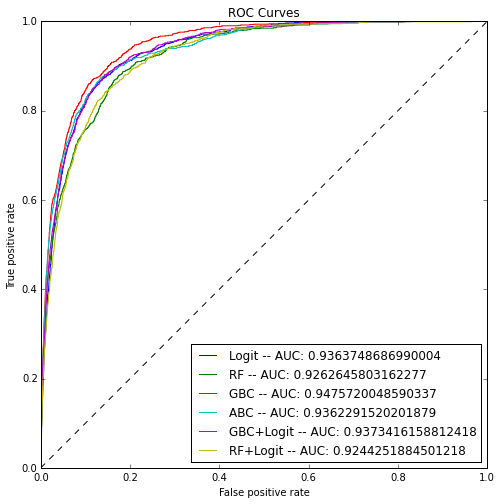

In [11]:
plt.figure(1, figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')

y_hats = [y_hat_logit, y_hat_RF, y_hat_GBC, y_hat_ABC, y_hat_GBC_logit, y_hat_RF_logit]
model_names = ['Logit', 'RF', 'GBC', 'ABC', 'GBC+Logit', 'RF+Logit']

for (y_hat, model_name) in zip(y_hats, model_names):
    FPR, TPR, thresholds = roc_curve(y_cv, y_hat)
    auc_score = auc(FPR, TPR)
    plt.plot(FPR, TPR, label= ('{} -- AUC: {}'.format(model_name, auc_score)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curves')
plt.legend(loc='best');


The best-performing model is GradientBoostingClassifier.

## 3. Prediction

In [12]:
model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=200)
fit = model.fit(X,y)
y_hat = fit.predict_proba(X)[:,1]
y_hat_class = fit.predict(X)

## 4. Cost-Benefit Analysis

In [13]:
tn, fp, fn, tp = confusion_matrix(y,y_hat_class).ravel()
print('TN:', tn, '-- FP:', fp,'-- FN:', fn,'-- TP:', tp)

TN: 69199 -- FP: 629 -- FN: 2238 -- TP: 1607


In [14]:
print(classification_report(y,y_hat_class))

             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98     69828
        1.0       0.72      0.42      0.53      3845

avg / total       0.96      0.96      0.96     73673



## 5. Findings and Conclusions
* The best-performing algorithm is Gradient Boosting with parameters learning_rate=0.1 and n_estimators=200
* This algorithm does a good job targeting the poor:
    * High Precision: Out of all the households identified as poor, 96% were actually poor.
    * High Recall: Out of all the poor households, 96% were correctly labeled as poor.
* If this method were to be used for subsidy-targeting purposes, subsidy leakage and undercoverage would be the minimum possible, at 4% each. With these data, this would translate into 629 households incorrectly being classified as poor and potentially receiving a subsidy they do not need, and 2,238 households being classified as non-poor, hence not receiving a subsidy they need.
* Next steps:
    * Include survey weights into analysis (feature 'v4611').
    * Compute profit curves with weighted survey to represent the entire country, and possible subsidy values.